# Problem 1: Beyond Lomb-Scargle

Lomb-Scargle is not the only option for period finding! Here we will implement another one, known as **conditional entropy** (https://arxiv.org/abs/1306.6664).

Let $m(t_i)$ be a time series of magnitudes. When we fold (or "phase fold") this time-series with period $p$, we calculate a **phase** $\phi_i$ for each point $i$ which ranges between -0.5 to 0.5. It is calculated

$$\phi_i = \frac{t_i}{p} - \Big[ \frac{t_i}{p} \Big]$$

where the square brackets denote "rounded to the nearest integer". (You've already seen "phase" values in your folded lightcurve plots during homework 5.)

To calculate the conditional entropy, we first pick a period $p$ and calculate the phase $\phi$ of every point in our time series. Then we divide the magnitudes and phases into evenly-spaced bins, calling the magnitude bins $m_i$ and the phase bins $\phi_j$. The phase bins should span from -0.5 to 0.5, while the magnitude bins should span from the minimum to the maximum magnitude in the data set.

The conditional entropy, $H(m|\phi)$, is then defined by:

\begin{equation}
H_c =  \sum_{i,j} p(m_i, \phi_j) \ln \left( \frac{p(\phi_j)}{p(m_i, \phi_j)} \right)
\end{equation}

Here,
- $p(m_i, \phi_j)$ is the "occupation probability" of bin $(m_i, \phi_j)$. In other words, it's the fraction of data points whose magnitude is in bin $m_i$ and whose phase is in bin $\phi_j$.
- $p(\phi_j)$ is the occupation probability of phase bin $\phi_j$, or the fraction of points whose phase is in bin $\phi_j$ **regardless** of magnitude. $p(\phi_j)$ can be related to $p(m_i, \phi_j)$ via

\begin{equation}
p(\phi_j) = \sum_i p(m_i, \phi_j)
\end{equation}

[Note: In $H_c$, the value $0 \log(c/0)$ for constant $c$ is generally considered to be 0, since $\lim_{x \to 0} x \log(c/x) = 0$. You'll need to check for this possibility.]

**If a periodic signal exists in the data with period $p$, then $H_c$ will have a local minimum with period $p$.** This period can be thought of as "minimizing the disorder" (ie. the "entropy") in the phase-folded light curve. In this problem, you will implement a function to calculte $H_c$ given $p$, then minimize it to find a best-fit period.

---

### Implement Conditional Entropy

Use the equations above, write the `CE` function so that it returns the conditional entropy of the data provided. We provide the function signature in the cell below.

In [87]:
def CE(period, data, xbins, ybins):
    """
    Returns the conditional entropy of *data* rephased with *period*.

    **Parameters**

    period : number
        The period to rephase *data* by.
    data : array-like, shape = [n_samples, 2] or [n_samples, 3]
        Array containing columns *time*, *mag*, and (optional) *error*.
    xbins : int
        Number of phase bins
    ybins : int
        Number of magnitude bins
    """
    
    ### YOUR CODE HERE
    

### Now, apply conditional entropy to real data to determine the best period

We will use the data in `cepheid.csv`, the same Cepheid time series data as in lecture 8. Below, we've loaded this data file and plotted it for you. Time values are stored in the variable `t` and magnitudes in `y`.

Text(0, 0.5, 'V Magnitude')

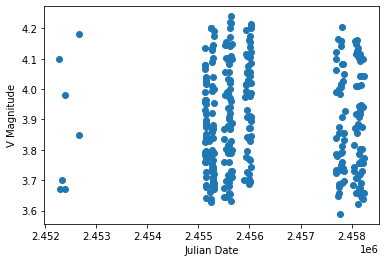

In [40]:
# Loads the relevant data file

import os
import numpy as np
import matplotlib.pyplot as plt

cwd = os.getcwd()
data_dir = os.path.join(cwd, 'datba')

data=np.loadtxt(os.path.join(data_dir,'cepheid.csv'),delimiter=',',skiprows=1)

t=data[:,0]
y=data[:,1]
plt.plot(t,y,ls='none', marker="o")
plt.xlabel('Julian Date')
plt.ylabel('V Magnitude')

We also provide the function below, which plots the phase-folded time series given a value for `period` in days:

In [155]:
# This function takes times t, mags y, and errors dy, and a period,
# and plots the phase-folded lightcurve at this period

def phase_fold(t,y,period):
    phases=np.remainder(t,period)/period - 0.5
#     phases=np.concatenate((phases))
#     y=np.concatenate((y,y))
    plt.plot(phases,y,ls='none',marker='o')
    plt.xlabel('Phase')
    plt.ylabel('Flux')


## Your task

Locate the minimum of your conditional entropy function to determine the best-fit period for your data. You can use any of the minimization methods we have used in lectures or homeworks to locate the best fit (except for `gatspy`).

Then, make a plot of "period" vs. "conditional entropy" for periods ranging +/-1 day around your best-fit period.

Hints:
- It may help to plot only one night (or a few nights) of your time series to get a rough estimate of a possible period.
- When provided the correct period, the plot from `phase_fold` should look very close to a sinusoid.
- Similarly, your final plot of period vs. conditional entropy should make it very clear which value is the best fit

In [156]:
# YOUR CODE HERE

# Problem 2: The period-luminosity relation of Cepheids in Galaxy NGC4258

Recall the **Leavitt law**: There is a linear relationship between the **absolute magnitude** and **log(period)** of Cepheid variable stars.

In this exercise, you will find a best-fit for the Leavitt law using Cepheid variable star data from [Riess et al., 2011](https://arxiv.org/abs/1103.2976). This data was used in the 2011 paper to estimate the Hubble constant, and it's the same data you've used in lectures 03 and 04. You'll fit this data using two models: The first model will only use the **observed error** in magnitude, while the second will include a term for **intrinsic error** (error in the Leavitt law itself) as well.

In the cell below, we've opened the data file and selected Cepheids from the galaxy NGC4258. We've stored their observed magnitudes as `mobs`, their log-periods as `logP`, and the observational error on their magnitudes as `sigma_obs`. We've also plotted this data.

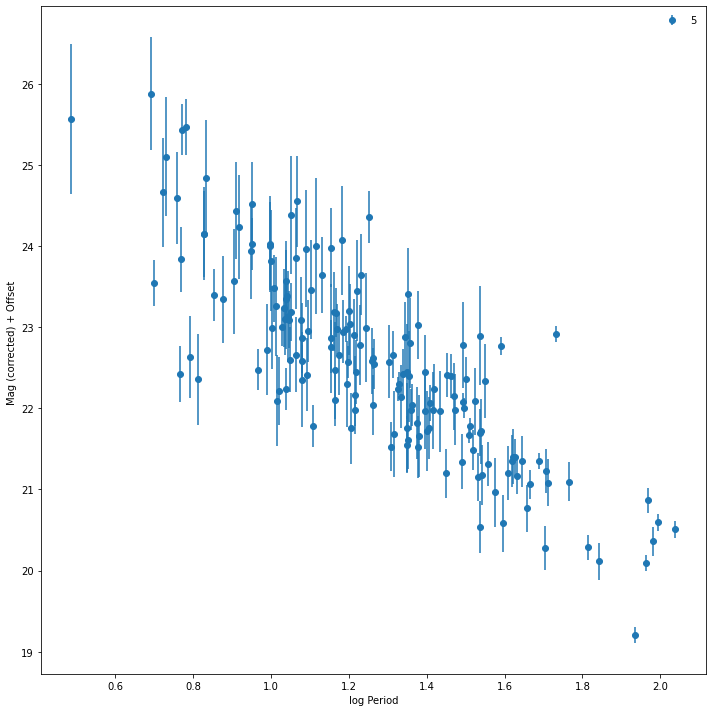

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt

exec(open('cepheids.py').read())
ceph = Cepheids('data/R11ceph.dat')
hosts = ceph.list_hosts()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ID = 5
host = hosts[ID]


ceph.select(host)
mobs = ceph.mobs
logP = ceph.logP
sigma_obs = ceph.sigma
ax.errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset')
fig.tight_layout()

---

## Model 1: Observational error only

Eqn. 1 of Riess et al. 2011 specifies the model they used to fit the Leavitt law. We will use a simplified version of this equation (we will include only one galaxy, and ignore the "metallicity" term).

The relation between Cepheid period and magnitude can be modeled as

$$ m_i = C + b \log P_i $$

for Cepheid magnitudes $m_i$, periods $P_i$, and model parameters $C$ and $b$.

### Your task

Write a function that calculates the log posterior probability of this model given the data. This should include contributions from an appropriately-chosen log prior and a log likelihood. (You can assume that we have perfect knowledge of Cepheid periods for this problem, and use only the error on the magnitude `sigma_obs`).

Then, use a Markov chain Monte Carlo method (MCMC) method to locate the best fit model.
- You may use any implementation of MCMC you wish. This includes the Metropolis Hastings function you wrote, the one provided in the homework solutions, or a Python package such as `emcee`.
- Make sure your MCMC walker has converged appropriately. You should check its acceptance rate (which should be around 25%) and create trace plots for each parameter (parameter value vs. step).
- Finally, make a note of the "burn-in period" - about how many steps does it take your MCMC walker to converge?

In [ ]:
# YOUR CODE HERE

---

## Model 2: Observational and intrinsic error

In the initial plot, you may notice that the error bars on some of the points are extremely small. This is true even for points that appear to be far away from the line of best fit!

The issue is that the Leavitt law is not exact. Even if we could observe the period and magnitude of every Cepheid variable star perfectly, these points would not form a perfect line. The **true** error on each point is a combination of both **intrinsic** error (from the actual magnitudes not precisely obeying the Leavitt law) and **observational** error (from imprecisely measuring the magnitudes).

We will assume that there is some intrinsic error $\sigma_{int}$ that is the same for every point.

Then for each Cepheid $i$, the true variance is the sum of the variance from each source of error:

$$\sigma_{true,i}^2 = \sigma_{obs,i}^2 + \sigma_{int}^2$$

for observational error $\sigma_{obs,i}$.

### Estimating $\sigma_{int}$

We have looked at "scaled residuals" a few times in the past, i.e. the residual on each point divided by the error:

$$\frac{(m_{obs,i} - m_{model})}{\sigma_{true,i}}$$

If we have correctly estimated the intrinsic error $\sigma_{int}$, then the distribution of "scaled residuals" should be **normally distributed with a standard deviation of 1.**

This provides a way to estimate $\sigma_{int}$. Using a minimization function, we can find the value of $\sigma_{int}$ that makes the standard deviation of these scaled residuals as close to 1 as possible.

### Your task

First, use the fit you just performed to show that the **observational** error on each point underestimates the true error.
- Plot your best fit model against your data, showing the observational errorbars (`sigma_obs`) with the `matplotlib` function `errorbar`. You should notice that, although your best fit line goes through the middle of your data, many points are far away from this best fit line compared to the size of their error bars $\sigma_{obs,i}$.
- Then, plot a histogram of "scaled residuals" using observational error only: $(m_{obs,i} - m_{model})/\sigma_{obs,i}$. You should see that the scaled residuals do NOT obey a normal distribution with standard deviation 1. To verify this, calculate and print their actual standard deviation.

Next, estimate the value of **intrinsic** error $\sigma_{int}$.
- Using a minimization method (eg: a grid search or `scipy.optimize.fmin`), estimate a value of $\sigma_{int}$ such that the scaled residuals $(m_{obs,i} - m_{model})/\sigma_{true,i}$ have a standard deviation that's close to 1.

Finally, find a new best fit with your MCMC walker (as with model 1), this time using $\sigma_{true,i}$ for each point. 
- Plot this best fit model against your data.
- Comment: Is it much different from the best fit from model 1? What might be an explanation for any differences you see?

In [154]:
# YOUR CODE HERE